# Anomaly detection k means

In [948]:
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [949]:
%run anomaly_detection_common.ipynb

## Loading dataset

In [950]:
dataset = ATSFDataset().load()
data_df = dataset.get_df()
data_df.head()

,timestamp,value_f,value_c,hours,daylight,day_of_the_week,week_day,time_epoch,categories
0,2013-07-04 00:00:00,69.880835,21.044908,0,0,3,1,13728960,2
1,2013-07-04 01:00:00,71.220227,21.789015,1,0,3,1,13728996,2
2,2013-07-04 02:00:00,70.877805,21.598781,2,0,3,1,13729032,2
3,2013-07-04 03:00:00,68.959400,20.533000,3,0,3,1,13729068,2
4,2013-07-04 04:00:00,69.283551,20.713084,4,0,3,1,13729104,2


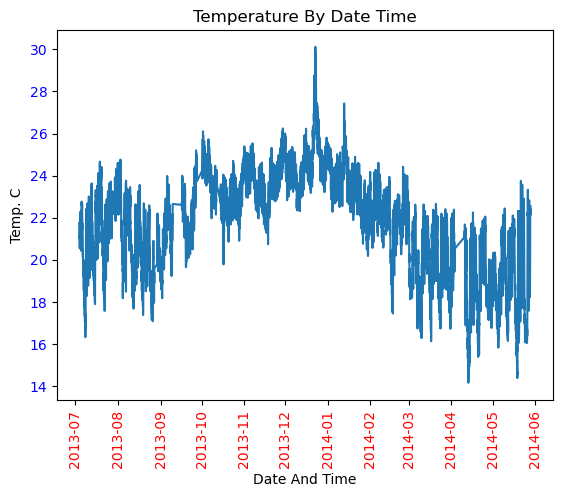

In [951]:
dataset.plot()

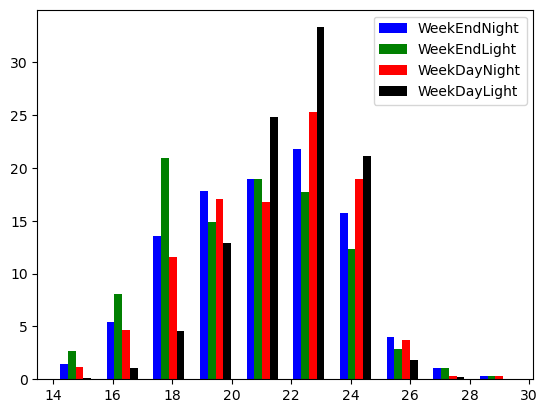

In [952]:
dataset.plot_categories()

In [953]:
# Take useful feature and standardize them
features = [ATSFDataset.Columns.VALUE_C, \
                    ATSFDataset.Columns.HOURS, \
                    ATSFDataset.Columns.DAYLIGHT, \
                    ATSFDataset.Columns.DAY_OF_THE_WEEK, \
                    ATSFDataset.Columns.WEEK_DAY]

features_df = data_df[features]
features_df.head()

,value_c,hours,daylight,day_of_the_week,week_day
0,21.044908,0,0,3,1
1,21.789015,1,0,3,1
2,21.598781,2,0,3,1
3,20.533000,3,0,3,1
4,20.713084,4,0,3,1


In [954]:
#Scalling the dataset with min max scaller
scaler = preprocessing.StandardScaler()
np_scaled = scaler.fit_transform(features_df)
scaled_df = pd.DataFrame(np_scaled, columns=features)
scaled_df.head()

,value_c,hours,daylight,day_of_the_week,week_day
0,-0.320586,-1.661537,-1.414798,0.005769,0.62132
1,-0.005228,-1.517172,-1.414798,0.005769,0.62132
2,-0.085851,-1.372807,-1.414798,0.005769,0.62132
3,-0.537536,-1.228442,-1.414798,0.005769,0.62132
4,-0.461215,-1.084077,-1.414798,0.005769,0.62132


In [955]:
# reduce to 2 importants features
pca = PCA(n_components=2)
np_reduced = pca.fit_transform(scaled_df)
reduced_df = pd.DataFrame(np_reduced, columns=['feature1', 'feature2'])

reduced_df.head()

,feature1,feature2
0,0.089870,2.238824
1,-0.012781,2.101394
2,-0.012707,2.012200
3,0.083627,1.968208
4,0.042987,1.859896


In [956]:
pca_df = pd.DataFrame(pca.components_, columns=scaled_df.columns, index = ['PC-1','PC-2'])
pca_df

,value_c,hours,daylight,day_of_the_week,week_day
PC-1,-0.259418,-0.144366,-0.129508,0.661575,-0.676318
PC-2,-0.121816,-0.685865,-0.679221,-0.165570,0.161233


In [957]:
# standardize these 2 new features
scaler = preprocessing.StandardScaler()
np_scaled = scaler.fit_transform(reduced_df)
train_df = pd.DataFrame(np_scaled, columns=reduced_df.columns)
train_df.head()

,feature1,feature2
0,0.066191,1.755363
1,-0.009413,1.647609
2,-0.009359,1.577677
3,0.061592,1.543184
4,0.031660,1.458262


In [958]:
class KMeansInfo():
    
    def __init__(self):
        self.max_clusters = None
        self.k_threshold = None
        self.max_score = None
        self.min_score = None
        self.score_range = None
        self.score_threshold = None
        self.best_score = None
        self.best_n_clusters = None
        self.outliers_fraction = None
        self.dataset_len = None
        self.outlier_number = None
        self.anomaly_threshold = None
        
    def info(self):
        print('K means algorithm run details:\n')
        print(f'Max clusters = {self.max_clusters}')
        print(f'K threshold = {self.k_threshold}')
        print(f'Max score = {round(self.max_score, 1)}')
        print(f'Min score = {round(self.min_score, 1)}')
        print(f'Score range = {round(self.score_range, 1)}')
        print(f'Score threshold = {round(self.score_threshold, 1)}')
        print(f'Best score = {round(self.best_score, 1)}')
        print(f'Best clusters No. = {self.best_n_clusters}')
        print(f'Dataset length = {self.dataset_len}')
        print(f'Outliers fraction = {self.outliers_fraction}')
        print(f'Number of outliers = {self.outlier_number}')
        print(f'Anomaly threshold = {self.anomaly_threshold}')

class KMeansConfiguration:
    
    def __init__(self, max_clusters, k_threshold, outliers_fraction):
        self.max_clusters = max_clusters
        self.k_threshold = k_threshold
        self.outliers_fraction = outliers_fraction

class ScoresDFColumns:
    N_CLUSTER = 'n_cluster'
    SCORE = 'score'
        
class KMeansAlgorithm:
    _configuration = None
    _kmeans = []
    
    def __init__(self, configuration):
        self._configuration = configuration
        
    def fit(self, df):
        max_clusters = self._configuration.max_clusters
        n_clusters_range = range(1, max_clusters)
        self._kmeans = [KMeans(n_clusters=i, n_init='auto').fit(df) for i in n_clusters_range]
        
        scores_range = range(len(self._kmeans))
        scores_tuples = [(i, self._kmeans[i].score(df)) for i in scores_range]

        scores_df = pd.DataFrame(columns=[ScoresDFColumns.N_CLUSTER, ScoresDFColumns.SCORE])
        scores_df[ScoresDFColumns.N_CLUSTER] = [t[0] for t in scores_tuples]
        scores_df[ScoresDFColumns.SCORE] = [t[1] for t in scores_tuples]
        
        self._scores = scores_df
        self._df_len = len(df)
        
    def get_scores(self):
        return self._scores
        
    def get_kmeans(self, n_clusters):
        return self._kmeans[n_clusters]
    
    def get_kmeans_collection(self):
        return self._kmeans
    
    def get_feature_cluster_map(self, df):
        kmeans_info = self.get_kmeans_info()
        
        cluster_count = kmeans_info.best_n_clusters
        outlier_number = kmeans_info.outlier_number
        
        kmeans_results_df = pd.DataFrame(columns=['cluster', 'feature1', 'feature2'])
        
        kmeans = self.get_kmeans_collection()
        kmeans_results_df['cluster'] = kmeans[cluster_count].predict(df)
        kmeans_results_df['feature1'] = df['feature1']
        kmeans_results_df['feature2'] = df['feature2']
        
        #Get the distance between each point and its nearest centroid. 
        #The biggest distances are considered as anomaly
        distances = self.get_distance_by_point(df, kmeans[cluster_count])        
        kmeans_results_df['distances'] = distances
        
        threshold = distances.nlargest(outlier_number).min()
        kmeans_results_df['is_anomaly'] = (distances >= threshold).astype(int)
        
        return kmeans_results_df
    
    def get_kmeans_info(self):
        max_score = self._scores[ScoresDFColumns.SCORE].max()
        min_score = self._scores[ScoresDFColumns.SCORE].min()
        score_range = max_score - min_score
        score_threshold = max_score - score_range * self._configuration.k_threshold
        
        kmeans_info = KMeansInfo()
        kmeans_info.max_clusters = self._configuration.max_clusters
        kmeans_info.k_threshold = self._configuration.k_threshold
        kmeans_info.max_score = max_score
        kmeans_info.min_score = min_score
        kmeans_info.score_range = score_range
        kmeans_info.score_threshold = score_threshold
        
        outliers_fraction = self._configuration.outliers_fraction
        outlier_number = int(outliers_fraction * self._df_len)
        
        kmeans_info.outliers_fraction = outliers_fraction
        kmeans_info.outlier_number = outlier_number
        
        best_score = None
        for score in self._scores[ScoresDFColumns.SCORE].values:
            if((best_score is None) and (score > score_threshold)):
                best_score = score
        
        kmeans_info.best_score = best_score
        kmeans_info.best_n_clusters = self._scores \
            .loc[self._scores[ScoresDFColumns.SCORE] == best_score, ScoresDFColumns.N_CLUSTER] \
            .values[0]
        
        kmeans_info.dataset_len = self._df_len
        
        return kmeans_info
    
    def plot_scores(self):
        df = self._scores
        
        x = df[ScoresDFColumns.N_CLUSTER]
        y = df[ScoresDFColumns.SCORE]
        
        fig, ax = plt.subplots()
        ax.plot(x, y)
        plt.show()
    
    
    def get_distance_by_point(self, df, model):
    
        df_len = len(df)
        distance = pd.Series()
        for i in range(0, df_len):
            point_coord = np.array(df.loc[i])
            centroid_coord = model.cluster_centers_[model.labels_[i]-1]
            distance.at[i] = np.linalg.norm(point_coord-centroid_coord)
        return distance
        

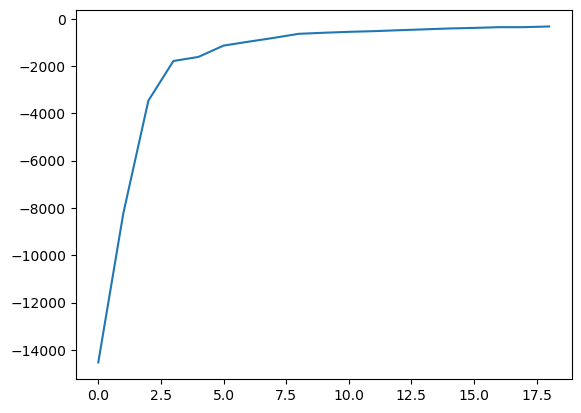

In [959]:
config = KMeansConfiguration(max_clusters=20, k_threshold = 0.01, outliers_fraction = 0.01)

model = KMeansAlgorithm(config)
model.fit(train_df)

model.plot_scores()

In [960]:
kmeans_info = model.get_kmeans_info()
kmeans_info.info()

K means algorithm run details:

Max clusters = 20
K threshold = 0.01
Max score = -328.3
Min score = -14534.0
Score range = 14205.7
Score threshold = -470.3
Best score = -450.4
Best clusters No. = 13
Dataset length = 7267
Outliers fraction = 0.01
Number of outliers = 72
Anomaly threshold = None


In [961]:
print(f'Chosing best cluster number = {kmeans_info.best_n_clusters} for the {kmeans_info.k_threshold} K threshold')

Chosing best cluster number = 13 for the 0.01 K threshold


In [962]:
#Running K means clustering algorithm with the optimal number of clusters
feature_cluster_map = model.get_feature_cluster_map(train_df)
feature_cluster_map.head()

C:\Users\inahshan\AppData\Local\Temp\ipykernel_35064\4012455451.py:145: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distance = pd.Series()


,cluster,feature1,feature2,distances,is_anomaly
0,5,0.066191,1.755363,1.783455,0
1,5,-0.009413,1.647609,1.815591,0
2,5,-0.009359,1.577677,1.794106,0
3,5,0.061592,1.543184,1.716262,0
4,5,0.031660,1.458262,1.723394,0


In [963]:
colors = {
    0:'red', 
    1:'blue', 
    2:'green', 
    3:'pink', 
    4:'black', 
    5:'orange', 
    6:'cyan', 
    7:'yellow', 
    8:'brown', 
    9:'purple', 
    10:'white', 
    11: 'grey', 
    12:'lightblue', 
    13:'lightgreen', 
    14: 'darkgrey'
}

In [964]:
cluster_sizes = feature_cluster_map['cluster'].value_counts()
cluster_sizes.sort_index(inplace=True)

In [965]:
clusters_df = pd.DataFrame(columns=['cluster_no', 'cluster_size', 'cluster_color'])
clusters_df['cluster_no'] = cluster_sizes.index.values
clusters_df['cluster_size'] = cluster_sizes.values
clusters_df['cluster_color'] = list(colors.values())[0:kmeans_info.best_n_clusters + 1]

clusters_df

,cluster_no,cluster_size,cluster_color
0,0,486,red
1,1,717,blue
2,2,356,green
3,3,663,pink
4,4,596,black
5,5,394,orange
6,6,558,cyan
7,7,616,yellow
8,8,608,brown
9,9,384,purple


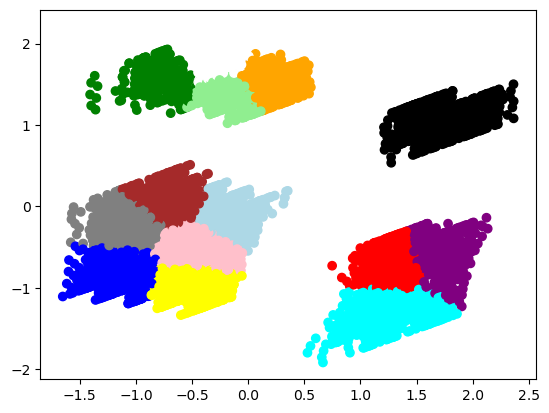

In [966]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
ax.scatter(feature_cluster_map['feature1'], \
           feature_cluster_map['feature2'], \
           c=feature_cluster_map["cluster"].apply(lambda x: colors[x]))
plt.show()

In [967]:
number_of_outliers = kmeans_info.outlier_number
print(f'Outlier number is {str(number_of_outliers)} for the outlier fraction of {kmeans_info.outliers_fraction}')

anomaly_summary = feature_cluster_map['is_anomaly'].value_counts()
anomaly_summary

Outlier number is 72 for the outlier fraction of 0.01


0    7195
1      72
Name: is_anomaly, dtype: int64

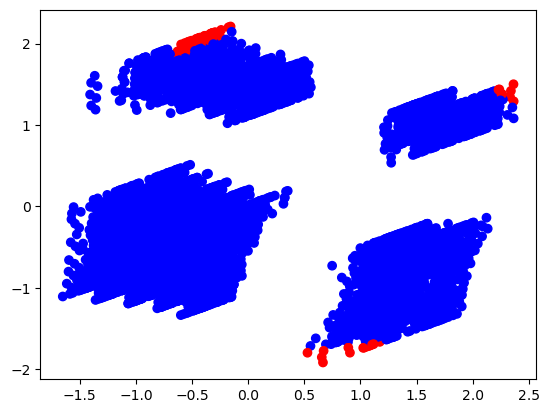

In [968]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(feature_cluster_map['feature1'], \
           feature_cluster_map['feature2'], \
           c=feature_cluster_map["is_anomaly"].apply(lambda x: colors[x]))
plt.show()

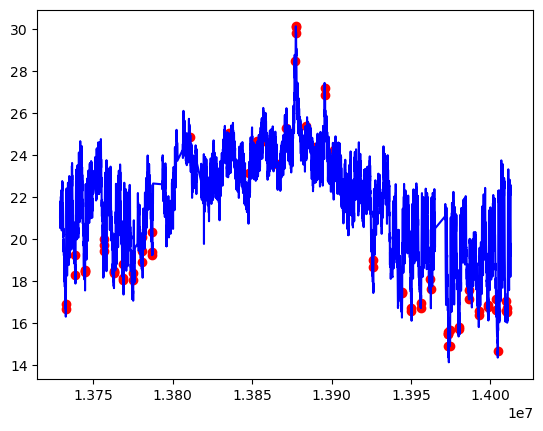

In [969]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = data_df.loc[feature_cluster_map['is_anomaly'] == 1, ['time_epoch', 'value_c']] #anomaly

ax.plot(data_df['time_epoch'], data_df['value_c'], color='blue')
ax.scatter(a['time_epoch'],a['value_c'], color='red')
plt.show()

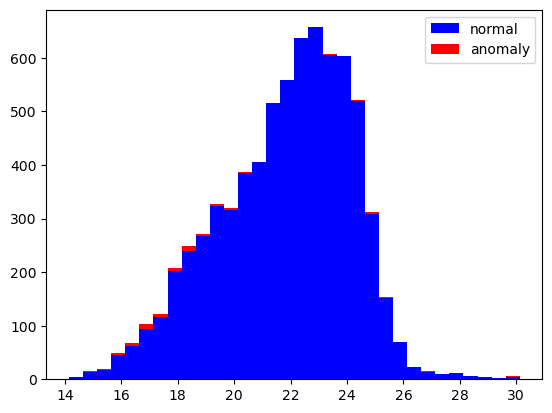

In [970]:
# visualisation of anomaly with temperature repartition (viz 2)
a = data_df.loc[feature_cluster_map['is_anomaly'] == 0, 'value_c']
b = data_df.loc[feature_cluster_map['is_anomaly'] == 1, 'value_c']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()